# Setup

In [13]:
%matplotlib inline

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

from dotenv import find_dotenv, load_dotenv

In [7]:
load_dotenv(find_dotenv())
repo_dir = os.environ['REPO_DIR']
output_images_dir = os.path.join(repo_dir, 'output_images')

In [8]:
img_path = os.path.join(repo_dir, 'output_images', 'test1.jpg')

In [11]:
img = mpimg.imread(img_path)

In [ ]:
# convert to HSL colour space
# S channel looks robust (#28 course notes) for identification of lanes (#29 quiz)
# R channel looks like its better at spotting white lines (#28 course notes)
# look to see if combining S and R works well (#24 course notes)

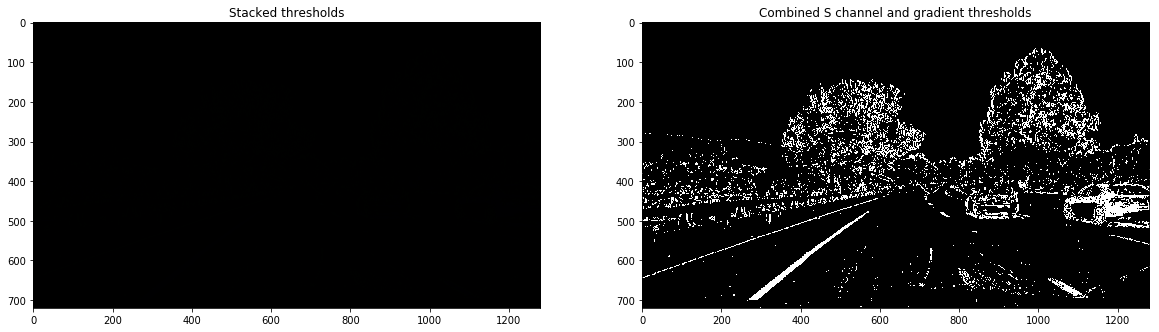

In [14]:
# example #1 from course notes #30

# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')

In [28]:
# example code #2 from course notes #30

# Edit this function to create your own pipeline.
def pipeline(img, colour_space, channel, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HSV color space and separate the V channel
    img = cv2.cvtColor(img, colour_space).astype(np.float)
    channel = img[:, :, channel]
    
    # Sobel x
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(channel)
    s_binary[(channel >= s_thresh[0]) & (channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

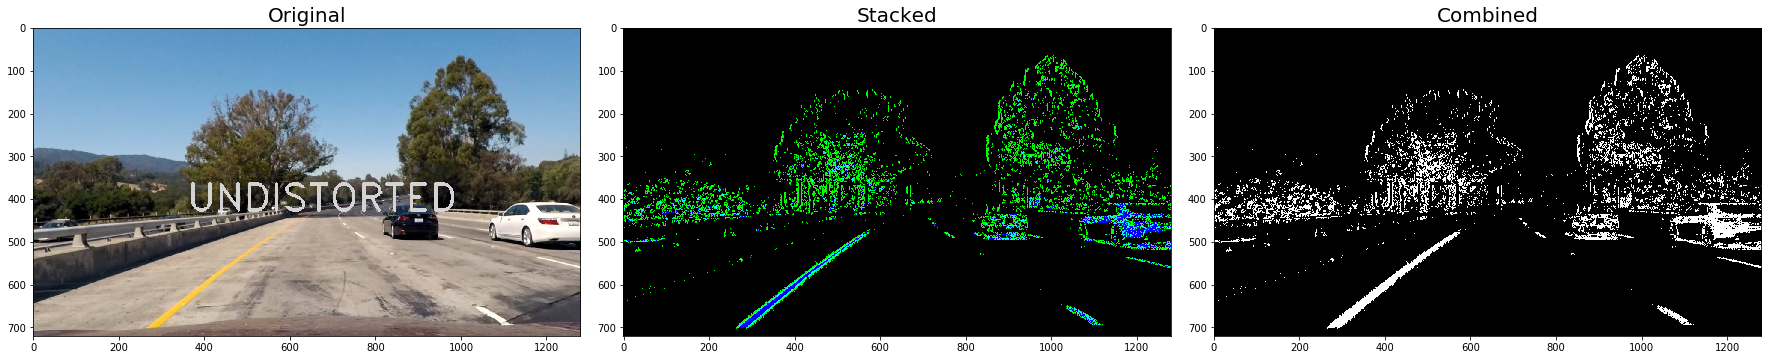

In [37]:
# change colour spaced and channel to ensure best result
colour_space = cv2.COLOR_RGB2HLS
channel = 2
color_binary, combined_binary = pipeline(img, colour_space, channel)

# plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original', fontsize=20)

ax2.imshow(color_binary)
ax2.set_title('Stacked', fontsize=20)

ax3.imshow(combined_binary, cmap='gray')
ax3.set_title('Combined', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 